# How does age impact NBA player performance over time?
### Term Project - DSC 530
by Darin Young - August 2024

## Introduction - Hypothesis

I have been a fan of the NBA for as long as I can remember - I envy those that got to watch the legendary era of the 90's while Michael Jordan and the Bulls formed one of the greatest dynasties in sports.  In my lifetime, I have seen many players start their career as rookies and end their careers - either due to age, injury or lack of ability. Typically speaking, the life cycle of an NBA player is around 10 years. However, some players exceed that mark, and in some cases significantly. In those cases, how does their performance stack up against their peers? In this project, I intend to explore the question: Does a players age have an impact on their performance in the NBA? And if so, how much?

My expectation is that, generally, age will have a negative impact on performance. There will certainly be outliers that perform great even into the late stages of their career, but my hypothesis is that the trend overall will be negative. 

#### Data

For this analysis, I used a dataset from Kaggle in which the user scraped data from Basketballreference.com, the industry standard when it comes to basketball statistics. 

The original Dataset can be found at: https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats/data?select=Team+Abbrev.csv

**Note:** For this analysis, I only used the "Player Totals" table. 

### Data Transformation/Cleaning

As is normal when working with a new dataset, it's rare that the data is in exactly the form/structure you need for your analysis. This dataset was not an exception. This section details my process for reshaping the data to fit my needs. 

In [729]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [304]:
df = pandas.read_csv("C:/Users/darin.young/Desktop/My Stuff/Online Learning/Bellevue University/DSC 530/Project/Player Totals.csv")

Some players had multiple entries in the dataset (if they played for more than one team during the season), such as player 3982 (Alec Burks) shown below. In these cases, they had a row for each team they played for and a row with a team value of 'TOT' to indicate their total for the season. However, players that only played for one team did not have a 'TOT' row. 

So, we need to first remove all rows with the 'TOT' designation so we can then aggregate each row by player/season. 

In [306]:
df.head(15)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,31136,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,...,0.895,9.0,55.0,64.0,30,9.0,4.0,12.0,49,252
1,31137,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,...,0.652,14.0,36.0,50.0,20,10.0,3.0,14.0,22,136
2,31138,2024,5027,AJ Griffin,NaN,SF,20.0,2,NBA,ATL,...,1.000,2.0,16.0,18.0,5,1.0,2.0,8.0,6,48
3,31139,2024,4219,Aaron Gordon,NaN,PF,28.0,10,NBA,DEN,...,0.658,174.0,297.0,471.0,259,56.0,45.0,105.0,142,1013
4,31140,2024,4582,Aaron Holiday,NaN,PG,27.0,6,NBA,HOU,...,0.921,23.0,100.0,123.0,140,42.0,6.0,53.0,125,514
5,31141,2024,4805,Aaron Nesmith,NaN,SF,24.0,4,NBA,IND,...,0.781,63.0,212.0,275.0,108,65.0,49.0,64.0,241,877
6,31142,2024,4900,Aaron Wiggins,NaN,SG,25.0,3,NBA,OKC,...,0.789,60.0,126.0,186.0,86,56.0,19.0,56.0,91,542
7,31143,2024,5109,Adam Flagler,NaN,SG,24.0,1,NBA,OKC,...,NaN,0.0,0.0,0.0,4,0.0,0.0,0.0,0,3
8,31144,2024,5110,Adama Sanogo,NaN,PF,21.0,1,NBA,CHI,...,0.667,19.0,17.0,36.0,0,1.0,0.0,5.0,5,36
9,31145,2024,4688,Admiral Schofield,NaN,PF,26.0,4,NBA,ORL,...,0.000,3.0,14.0,17.0,7,1.0,0.0,5.0,9,26


The following code removes all rows containing 'TOT' in the team column. The resulting table is shown below. Pay close attention to Alec Burks and take note that he only has two teams, DET and NYK. 

In [174]:
df = df[df['tm'] != 'TOT']
df.head(15)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,31136,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,...,0.895,9.0,55.0,64.0,30,9.0,4.0,12.0,49,252
1,31137,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,...,0.652,14.0,36.0,50.0,20,10.0,3.0,14.0,22,136
2,31138,2024,5027,AJ Griffin,NaN,SF,20.0,2,NBA,ATL,...,1.000,2.0,16.0,18.0,5,1.0,2.0,8.0,6,48
3,31139,2024,4219,Aaron Gordon,NaN,PF,28.0,10,NBA,DEN,...,0.658,174.0,297.0,471.0,259,56.0,45.0,105.0,142,1013
4,31140,2024,4582,Aaron Holiday,NaN,PG,27.0,6,NBA,HOU,...,0.921,23.0,100.0,123.0,140,42.0,6.0,53.0,125,514
5,31141,2024,4805,Aaron Nesmith,NaN,SF,24.0,4,NBA,IND,...,0.781,63.0,212.0,275.0,108,65.0,49.0,64.0,241,877
6,31142,2024,4900,Aaron Wiggins,NaN,SG,25.0,3,NBA,OKC,...,0.789,60.0,126.0,186.0,86,56.0,19.0,56.0,91,542
7,31143,2024,5109,Adam Flagler,NaN,SG,24.0,1,NBA,OKC,...,NaN,0.0,0.0,0.0,4,0.0,0.0,0.0,0,3
8,31144,2024,5110,Adama Sanogo,NaN,PF,21.0,1,NBA,CHI,...,0.667,19.0,17.0,36.0,0,1.0,0.0,5.0,5,36
9,31145,2024,4688,Admiral Schofield,NaN,PF,26.0,4,NBA,ORL,...,0.000,3.0,14.0,17.0,7,1.0,0.0,5.0,9,26


Now that we have removed the total rows, we can aggregate rows by player/season. The following code sums all of the numeric columns and finds the maximum value for age. 

In [148]:
df_combined = df.groupby(['player_id','season']).agg({
    'age': 'max',
    'pts': 'sum',
    'mp': 'sum',
    'tov': 'sum',
    'fg': 'sum',
    'fga': 'sum',
    'x3p': 'sum',
    'x3pa': 'sum',
    'x2p': 'sum',
    'x2pa': 'sum',
    'ft': 'sum',
    'fta': 'sum',
}).reset_index()

The original dataset included columns for 3 point, 2 point, free throw and effective field goal percentage. Rather than aggregating each of those values and finding an appropriate method to apply weight to each year (based on minutes played or games played, for example), I instead decided to create my own columns using the aggregated columns. 

For example, the new column created below called "x3p_percent" divides the number of 3p makes by the number of 3p attempts and then multiplies by 100 to represent the value as a percentage. 

Additionally, I manually created a column for "Effective Field Goal %" (eFG%) rather than aggregating from the original dataset. eFG% is defined as:$^{1}$ $$eFG\% = \frac{FG + (0.5 \times 3P)}{FGA}$$
With that in mind, I calculated this metric as a new column named "e_fg_percent."

All column calculations are shown below.


In [179]:
df_combined['x3p_percent'] = (df_combined['x3p'] / df_combined['x3pa']) * 100
df_combined['x2p_percent'] = (df_combined['x2p'] / df_combined['x2pa']) * 100
df_combined['ft_percent'] = (df_combined['ft'] / df_combined['fta']) * 100
df_combined['e_fg_percent'] = ((df_combined['fg'] + (0.5 * df_combined['x3p'])) / df_combined['fga']) * 100

An updated look at the dataset after the changes made to this point. 

In [196]:
df_combined.head(10)

,player_id,season,age,pts,mp,tov,fg,fga,x3p,x3pa,x2p,x2pa,ft,fta,x3p_percent,x2p_percent,ft_percent,e_fg_percent
0,1,1947,23.0,567,0.0,0.0,223,870,0.0,0.0,223,870,121,193,NaN,25.632184,62.694301,25.632184
1,2,1947,26.0,4,0.0,0.0,1,8,0.0,0.0,1,8,2,5,NaN,12.500000,40.000000,12.500000
2,3,1947,25.0,31,0.0,0.0,13,69,0.0,0.0,13,69,5,8,NaN,18.840580,62.500000,18.840580
3,4,1947,28.0,562,0.0,0.0,230,818,0.0,0.0,230,818,102,123,NaN,28.117359,82.926829,28.117359
4,4,1948,29.0,319,0.0,0.0,134,485,0.0,0.0,134,485,51,73,NaN,27.628866,69.863014,27.628866
5,4,1949,30.0,478,0.0,0.0,194,618,0.0,0.0,194,618,90,119,NaN,31.391586,75.630252,31.391586
6,5,1947,23.0,532,0.0,0.0,224,929,0.0,0.0,224,929,84,114,NaN,24.111948,73.684211,24.111948
7,5,1948,24.0,368,0.0,0.0,152,512,0.0,0.0,152,512,64,106,NaN,29.687500,60.377358,29.687500
8,5,1949,25.0,596,0.0,0.0,206,650,0.0,0.0,206,650,184,285,NaN,31.692308,64.561404,31.692308
9,5,1950,26.0,477,0.0,0.0,160,574,0.0,0.0,160,574,157,205,NaN,27.874564,76.585366,27.874564


The observant of you might notice the null values in mp and x3pa/x3p/x3p_percent. Let's take a closer look at those in a few scatter plots.

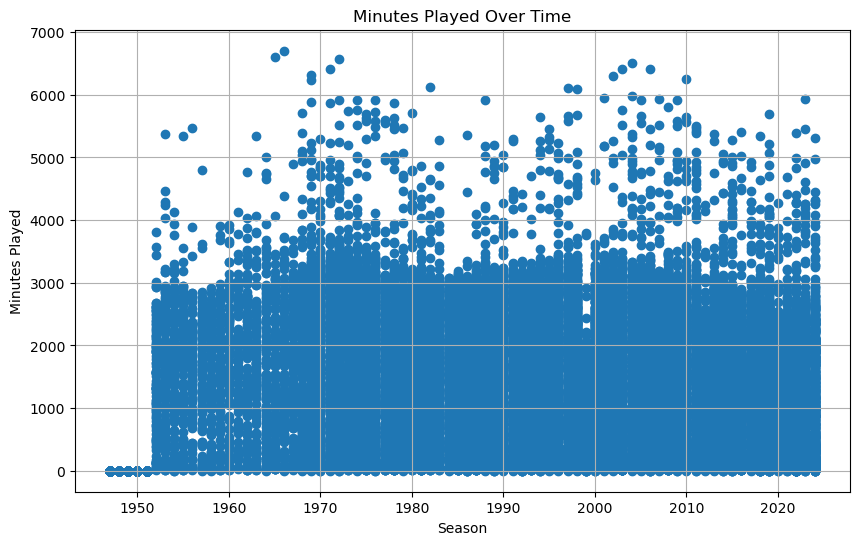

In [201]:
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['season'], df_combined['mp'])

plt.title('Minutes Played Over Time')
plt.xlabel('Season')
plt.ylabel('Minutes Played')
plt.grid(True)
plt.show()

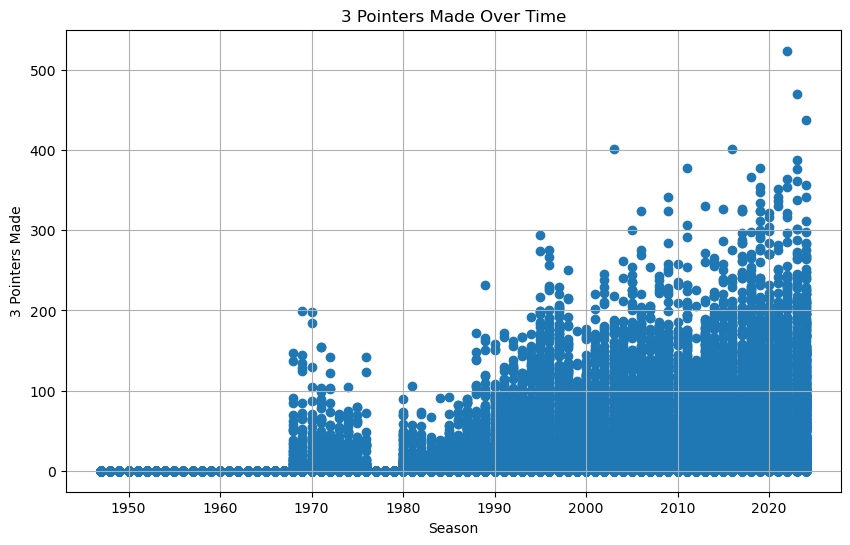

In [313]:
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['season'], df_combined['x3p'])

plt.title('3 Pointers Made Over Time')
plt.xlabel('Season')
plt.ylabel('3 Pointers Made')
plt.grid(True)
plt.show()

The scatter plots show that minutes played was not a tracked statistic until the early 50s, and 3 pointers were tracked for a short time in the late 60s-early 70s and then started being tracked consistently after 1980. I am unsure why minutes played was not tracked prior to the early 50s - however, I can explain the exclusion of 3 point related stats until the 80s - the 3 point shot was not adopted to the NBA until 1979.$^{2}$

Side note: the small blip in the late 60s and early 70s is explained the by the ABA adopting the 3 point shot in 1967.$^{2}$

With all of this in mind, my analysis will only include records for players after 1980, to be ensure I can include 3 point related stats in my analysis. 

In [798]:
df_filtered = df_combined[df_combined['season'] >= 1980]

In [800]:
df_filtered.head(10)

,player_id,season,age,pts,mp,tov,fg,fga,x3p,x3pa,x2p,x2pa,ft,fta,x3p_percent,x2p_percent,ft_percent,e_fg_percent
2837,834,1980,36.0,315,1595.0,83.0,113,299,0.0,0.0,113,299,89,136,NaN,37.792642,65.441176,37.792642
3020,856,1980,35.0,866,1816.0,152.0,325,771,73.0,221.0,252,550,143,153,33.031674,45.818182,93.464052,46.887160
3493,949,1980,35.0,378,633.0,28.0,161,352,0.0,0.0,161,352,56,64,NaN,45.738636,87.500000,45.738636
3748,1021,1980,34.0,65,194.0,9.0,29,46,0.0,2.0,29,44,7,10,0.000000,65.909091,70.000000,63.043478
3876,1061,1980,34.0,10,27.0,4.0,4,11,0.0,1.0,4,10,2,2,0.000000,40.000000,100.000000,36.363636
3987,1092,1980,33.0,167,523.0,33.0,67,189,1.0,6.0,66,183,32,42,16.666667,36.065574,76.190476,35.714286
4020,1101,1980,34.0,1859,3183.0,215.0,761,1677,3.0,13.0,758,1664,334,478,23.076923,45.552885,69.874477,45.468098
4021,1101,1981,35.0,1439,2931.0,189.0,584,1296,0.0,10.0,584,1286,271,439,0.000000,45.412131,61.731207,45.061728
4022,1101,1982,36.0,1318,3032.0,208.0,519,1100,0.0,5.0,519,1095,280,422,0.000000,47.397260,66.350711,47.181818
4023,1101,1983,37.0,1046,2302.0,200.0,424,890,2.0,4.0,422,886,196,287,50.000000,47.629797,68.292683,47.752809


## Distribution

#### Histograms

For my analysis, I plan to evaluate the effect that age has on a player's performance. To do so, I will utilize the following variables: x3p_percent, x2p_percent, e_fg_percent, ft_percent, pts (points), mp (minutes played) and tov (turnovers). 

Here are histograms for each variable. 

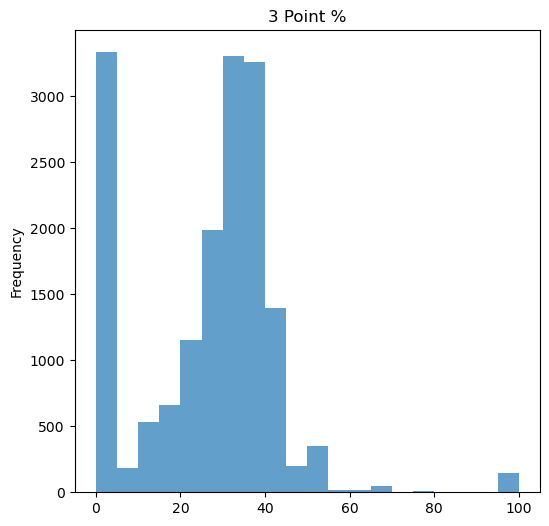

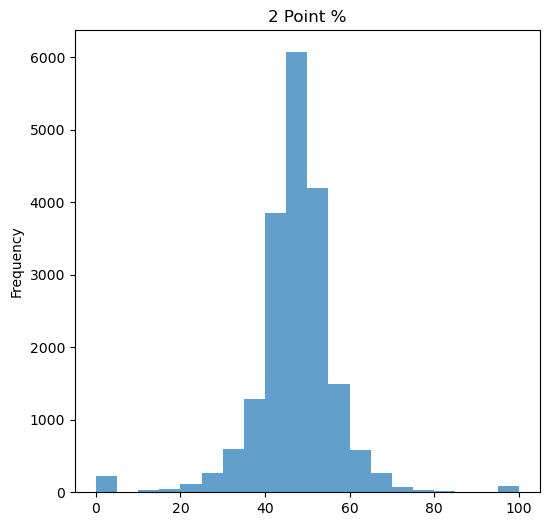

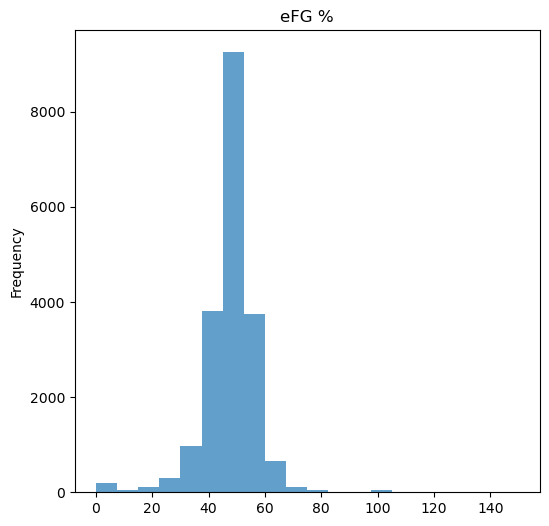

In [802]:
plt.figure(figsize=(6, 6))
plt.hist(df_filtered['x3p_percent'].dropna(), bins=20, alpha=0.7)
plt.title('3 Point %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(df_filtered['x2p_percent'].dropna(), bins=20, alpha=0.7)
plt.title('2 Point %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(df_filtered['e_fg_percent'].dropna(), bins=20, alpha=0.7)
plt.title('eFG %')
plt.ylabel('Frequency')
plt.show()

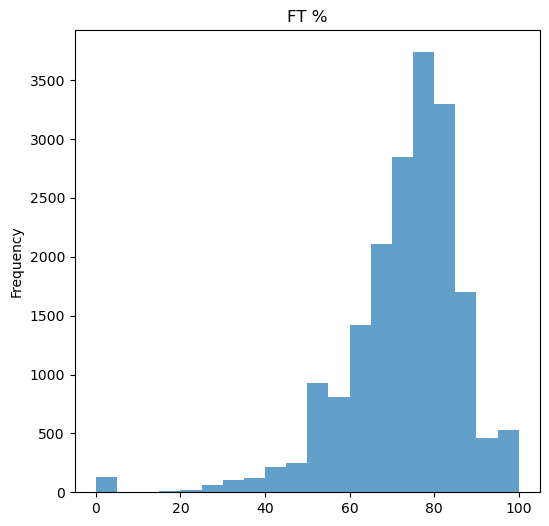

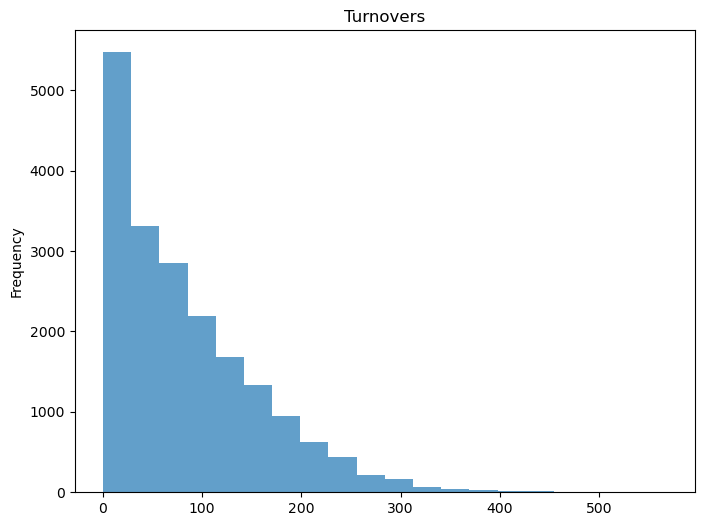

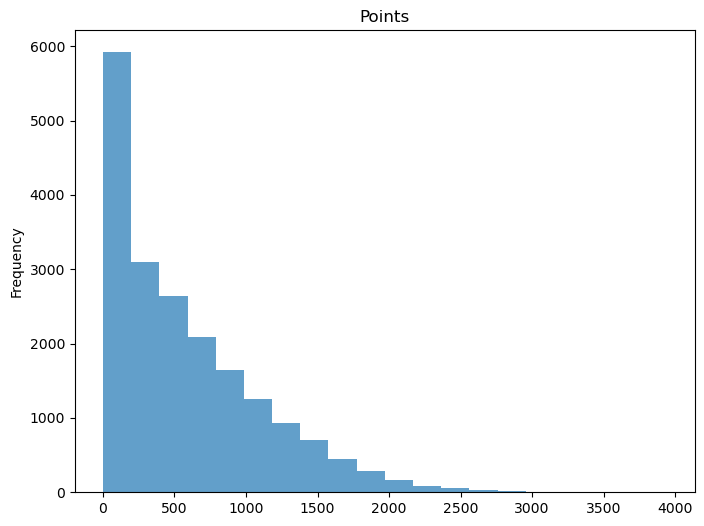

In [334]:
plt.figure(figsize=(6, 6))
plt.hist(df_filtered['ft_percent'].dropna(), bins=20, alpha=0.7)
plt.title('FT %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_filtered['tov'].dropna(), bins=20, alpha=0.7)
plt.title('Turnovers')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_filtered['pts'].dropna(), bins=20, alpha=0.7)
plt.title('Points')
plt.ylabel('Frequency')
plt.show()

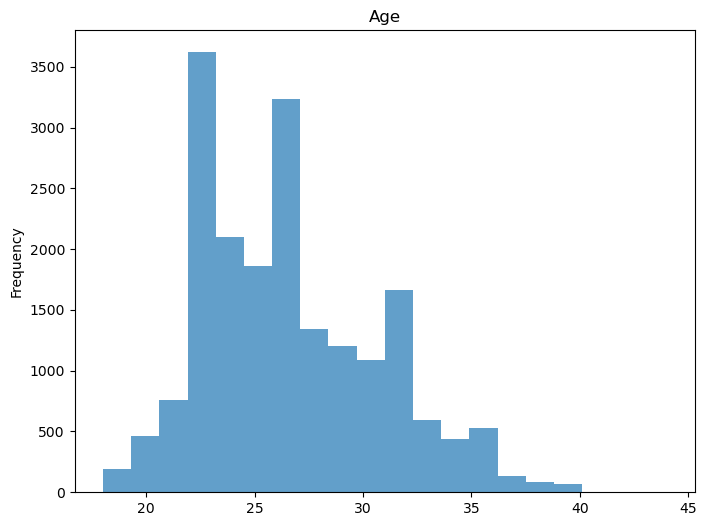

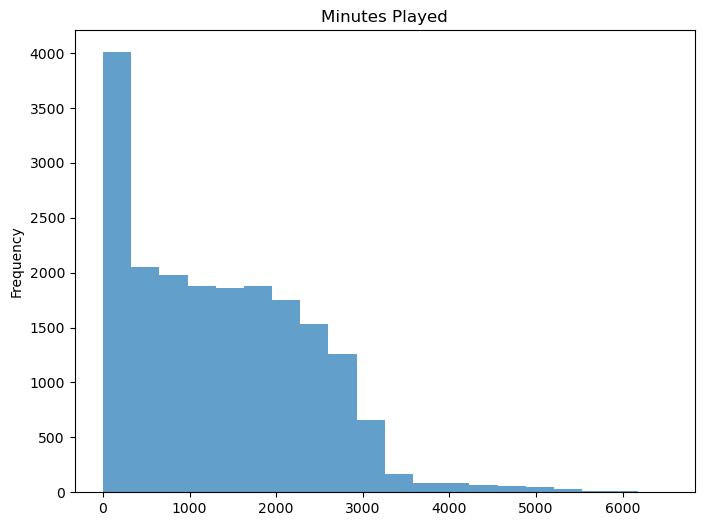

In [350]:
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['age'].dropna(), bins=20, alpha=0.7)
plt.title('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_filtered['mp'].dropna(), bins=20, alpha=0.7)
plt.title('Minutes Played')
plt.ylabel('Frequency')
plt.show()

After looking at the histograms, I made these observations:

1. 2 Point %, FT %, eFG % and Age all seem to be normally distributed. I won't be addressing these in any way.
2. Minutes played, points, turnovers and 3 Point % seem to skewed toward 0. Minutes played, points and turnovers are expected to have this distribution - players are much more likely to score less points in their career as opposed to more. Moreover, there isn't an "expected average" of points scored for a players career that most players reach. The same logic can be applied to the other two variables. With this said, I won't be addressing these variables further. 
3. 3 Point %, however, should be normally distributed, logically - NBA caliber players should probably be capable of making around the same percent of 3 point shots as their peers. Some might make 20%, others might make 50%. In either case, there should be a league average in which all other players should be normally distributed around. With that said, aside from the huge spike at 0%, the histogram does show a normal distribution around 38% or so. To address this, I am going to exclude players that have less than 15 3 pointers attempted in their career. After digging into the data further, there are many players that attempt very few 3 point shots in their career. If, for example, a player only attempts two 3 point shots in his career and makes neither, he will have a career 3 Point % of 0%. Realistically, after more attempts, that player would be more likely to make at least one. With that said, excluding those types of players should help to smooth the distribution.

**Note:** This exclusion will also help to weed out players that just generally didn't get much play time during their career, which will strengthen the analysis overall. This is reinforced below.

After these changes, let's take a look at the histograms again. 

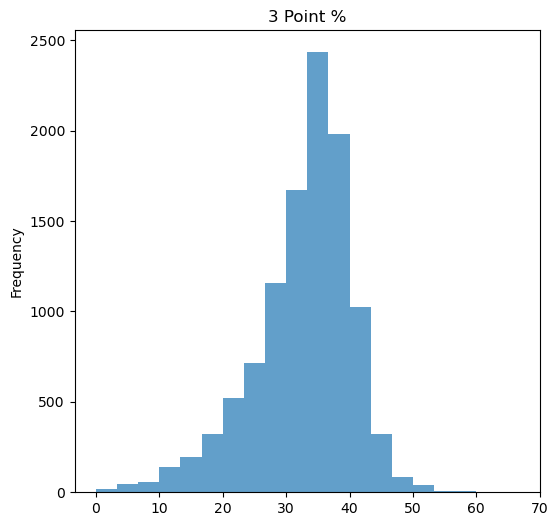

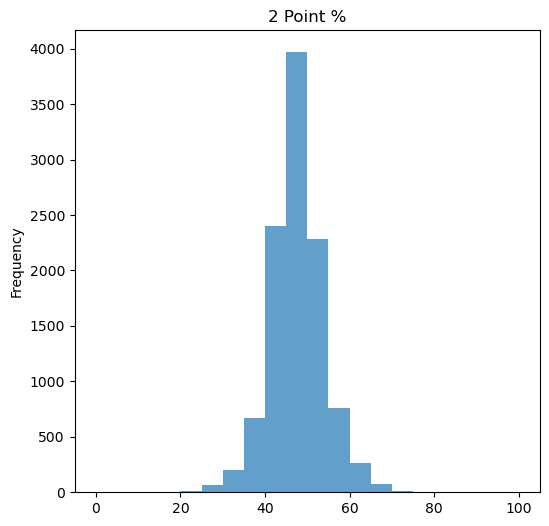

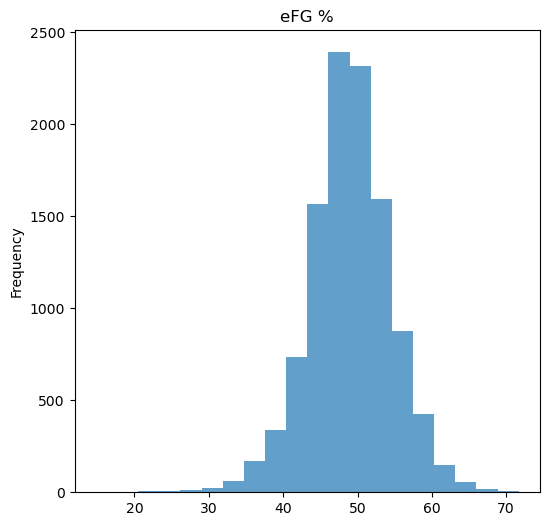

In [395]:
df_final = df_filtered[df_filtered['x3pa'] >= 15]

plt.figure(figsize=(6, 6))
plt.hist(df_final['x3p_percent'].dropna(), bins=20, alpha=0.7)
plt.title('3 Point %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(df_final['x2p_percent'].dropna(), bins=20, alpha=0.7)
plt.title('2 Point %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(df_final['e_fg_percent'].dropna(), bins=20, alpha=0.7)
plt.title('eFG %')
plt.ylabel('Frequency')
plt.show()

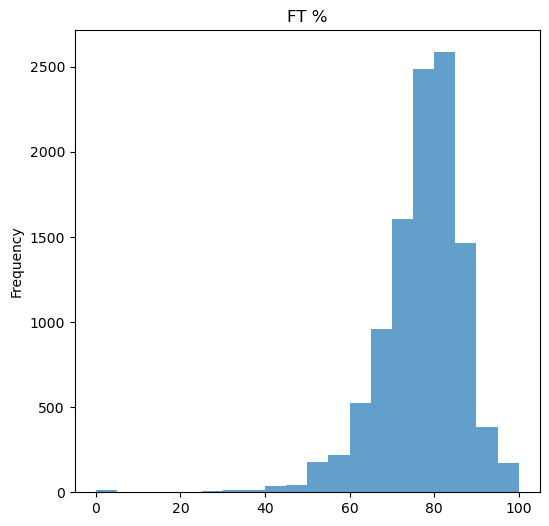

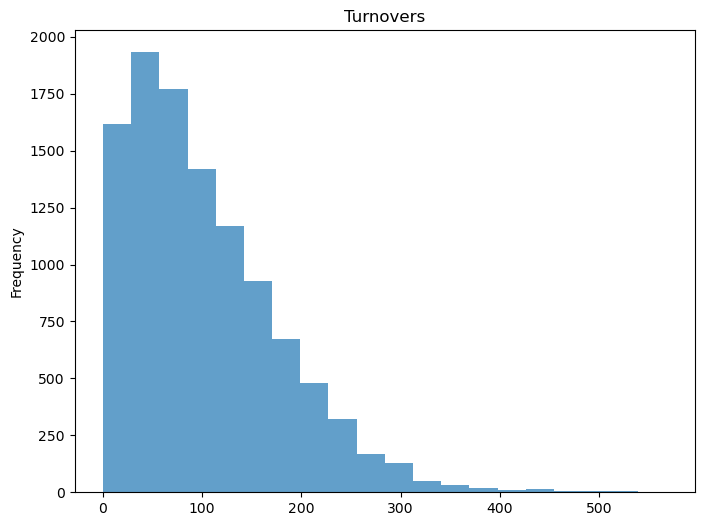

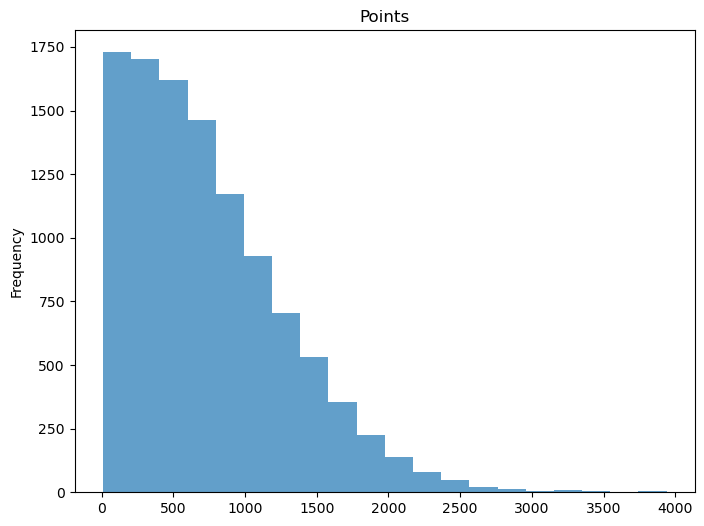

In [397]:
plt.figure(figsize=(6, 6))
plt.hist(df_final['ft_percent'].dropna(), bins=20, alpha=0.7)
plt.title('FT %')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_final['tov'].dropna(), bins=20, alpha=0.7)
plt.title('Turnovers')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_final['pts'].dropna(), bins=20, alpha=0.7)
plt.title('Points')
plt.ylabel('Frequency')
plt.show()

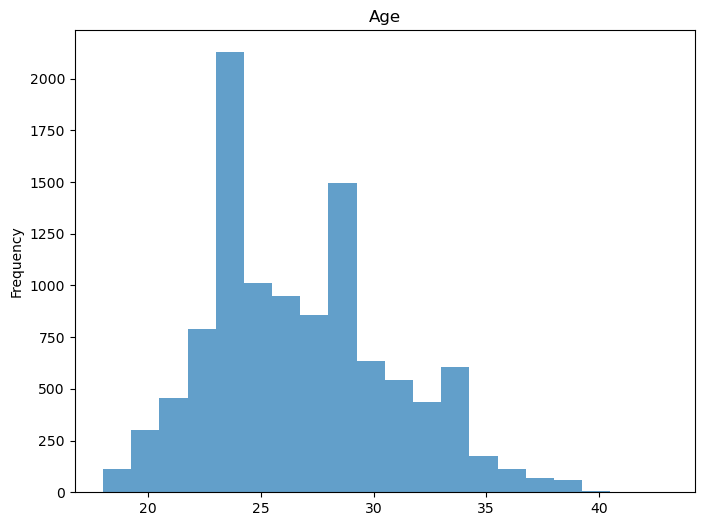

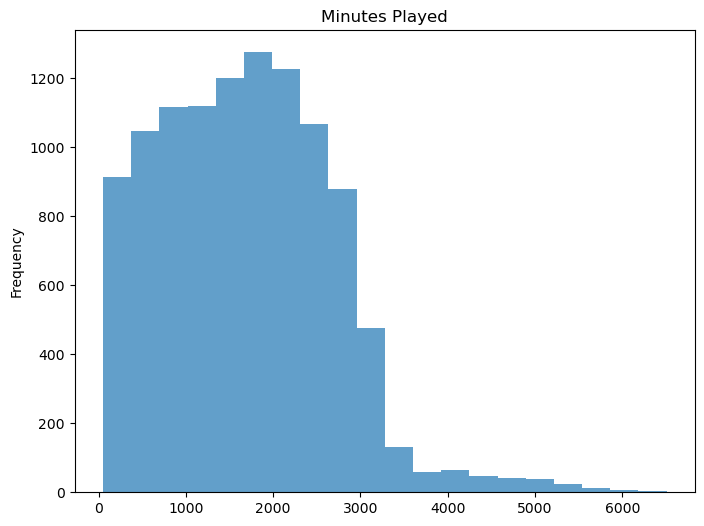

In [399]:
plt.figure(figsize=(8, 6))
plt.hist(df_final['age'].dropna(), bins=20, alpha=0.7)
plt.title('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_final['mp'].dropna(), bins=20, alpha=0.7)
plt.title('Minutes Played')
plt.ylabel('Frequency')
plt.show()

After looking at these histograms one last time, they all look much better in terms of their distribution. Specifically, I'd like to call out the change to minutes played. Previously, there was a large spike around 0. After weeding out players with less than 15 3 point attempts, there are far fewer players with values close to 0, and more players near the mean value of ~2000. Presumably, this reinforces what I mentioned earlier - players with 0% 3 point shooting probably did not have much playing time in the NBA and therefore had minimal opportunity to achieve a normal shooting percentage. 

#### Descriptive Statistics

The following code is a table of descriptive statistics about the relevant columns - player id and season are excluded as they are not numeric, by nature. 

The things that stick out to me at this point are:

1. There are huge standard deviations for many variables. Specifically, minutes played varies around the mean very widely. This can probably be attributed mainly to players who have extraordinarly long careers compared to their peers (see: Lebron James, Udonis Haslem, Vince Carter).
2. Most players, while playing in the NBA, are between the ages of 22 and 30. This makes sense as it relates to physical peaks happening during that time.
3. NBA players are generally very consistent at making free throws - most players make between 67% and 87% of their free throw attempts. 

In [421]:
numeric_columns = set(df_final.columns) - {'player_id'} - {'season'}
df_temp = df_final[list(numeric_columns)]
df_temp.describe()

,x3p,x3pa,fta,x3p_percent,pts,tov,ft,x2pa,age,fga,x2p,ft_percent,e_fg_percent,mp,fg,x2p_percent
count,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10747.000000,10708.000000,10747.000000,10747.000000,10747.000000,10747.000000
mean,59.491951,167.395552,168.286219,32.584194,747.054620,102.825719,132.431562,450.982879,26.646506,618.378431,218.073602,77.129931,49.013023,1689.337490,277.565553,47.576960
std,58.189431,151.740138,154.707176,7.829159,547.489173,76.071091,125.225853,367.325479,4.081458,431.451689,181.852817,9.910503,5.529518,981.935707,202.710673,6.579532
min,0.000000,15.000000,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000,18.000000,18.000000,0.000000,0.000000,14.814815,50.000000,4.000000,0.000000
25%,14.000000,47.000000,54.000000,28.571429,312.000000,44.000000,40.000000,164.000000,23.000000,275.000000,76.000000,72.267374,45.751862,914.000000,115.000000,44.017978
50%,41.000000,122.000000,123.000000,33.877551,640.000000,86.000000,94.000000,359.000000,26.000000,543.000000,171.000000,78.409091,49.000000,1661.000000,239.000000,47.509579
75%,88.000000,244.000000,237.000000,37.800620,1065.000000,146.000000,187.000000,652.000000,29.000000,879.000000,316.000000,83.486239,52.375489,2356.000000,398.000000,51.048951
max,524.000000,1432.000000,1340.000000,66.666667,3940.000000,568.000000,1034.000000,2756.000000,43.000000,3176.000000,1268.000000,100.000000,71.666667,6508.000000,1396.000000,100.000000


#### Spread 
#### Box Plots

To visualize the spread of each of the metrics, I will use box plots.

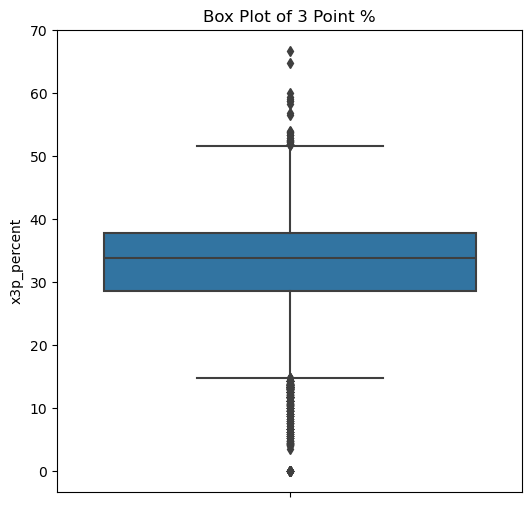

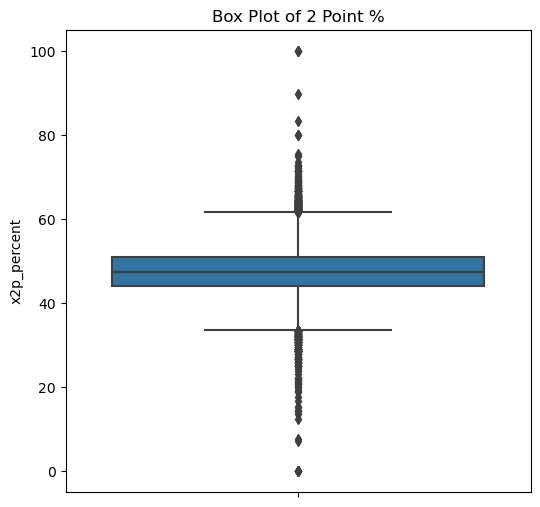

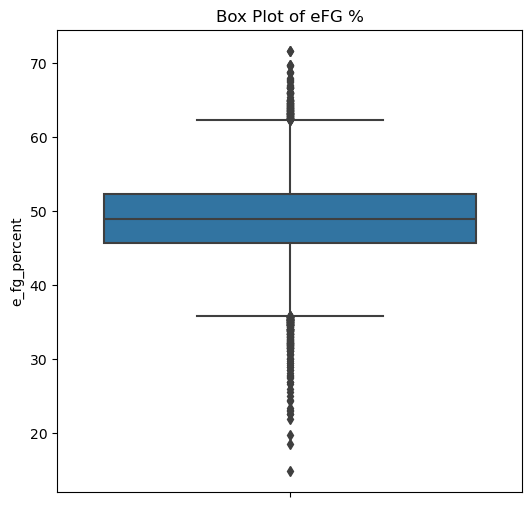

In [476]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['x3p_percent'].dropna())
plt.title('Box Plot of 3 Point %')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['x2p_percent'].dropna())
plt.title('Box Plot of 2 Point %')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['e_fg_percent'].dropna())
plt.title('Box Plot of eFG %')
plt.show()

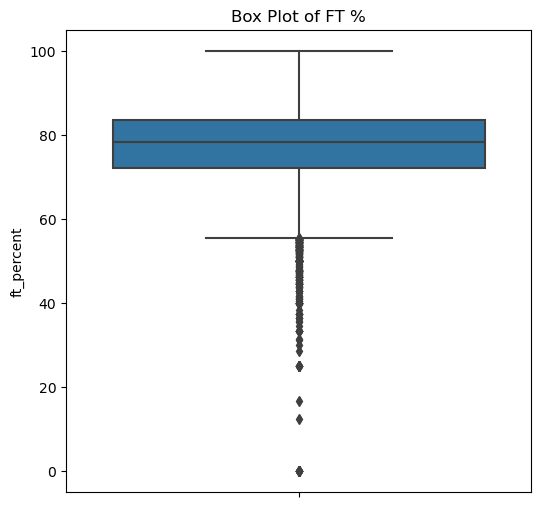

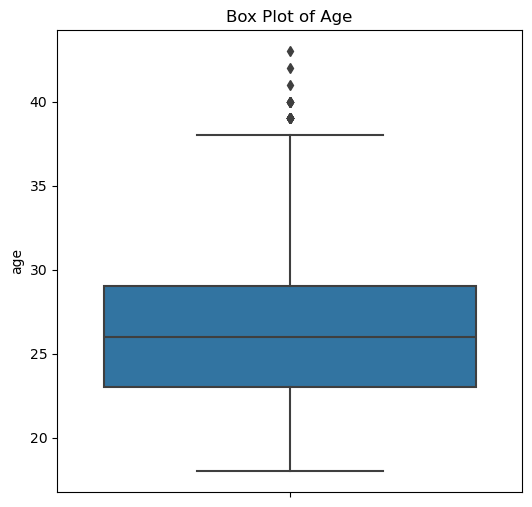

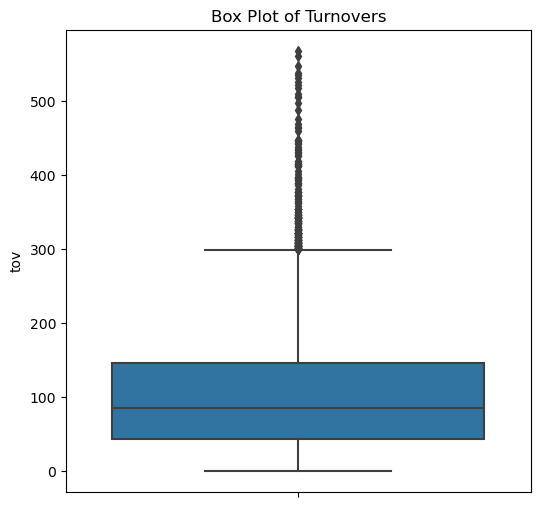

In [478]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['ft_percent'].dropna())
plt.title('Box Plot of FT %')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['age'].dropna())
plt.title('Box Plot of Age')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['tov'].dropna())
plt.title('Box Plot of Turnovers')
plt.show()

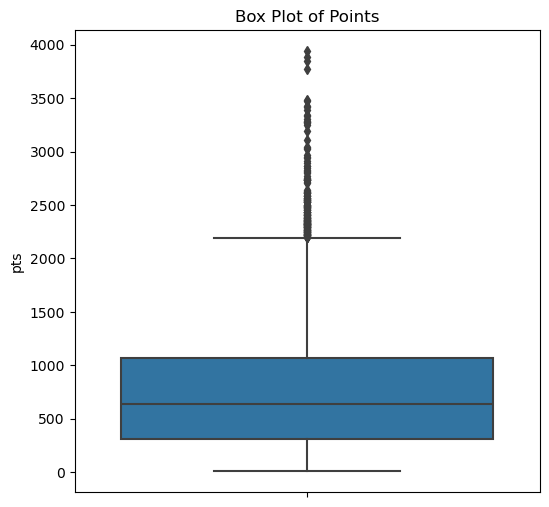

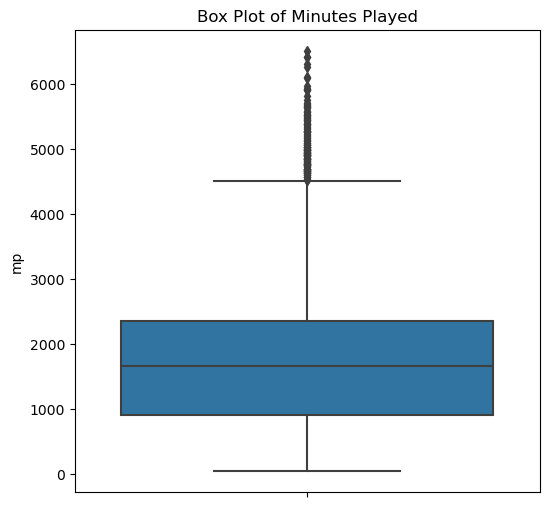

In [448]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['pts'].dropna())
plt.title('Box Plot of Points')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=df_final['mp'].dropna())
plt.title('Box Plot of Minutes Played')
plt.show()

A couple of observations about these box plots:

1. A large number of players play less than 2,500 minutes in their career. However, there are also a very large number of outliers that play more than 4,500 minutes. Those are likely the guys that we all know and love to watch - the Hall of Famers (The same can be said about points scored, by the way).
2. As mentioned previously, most players are between 22 and 30, with a few outliers playing into their 40s.
3. Effective field goal percentage for most players is between 40% and 60%. If I had to guess, the advent of the 3 point shot has certainly helped that statistic in a positive way. 

#### Tails - Skewness/Kurtosis

A further method to evaluating the distribution of the data is calculating and visualizing the skewness/kurtosis values. This will help give us a better understanding of the *tilt* of the data. 

In [505]:
from scipy.stats import skew, kurtosis

metrics = ['x3p_percent', 'x2p_percent', 'e_fg_percent', 'ft_percent', 'age', 'tov','pts', 'mp']

for metric in metrics:
    skewness = skew(df_final[metric].dropna())
    kurt = kurtosis(df_final[metric].dropna())
    print(f'{metric}: Skewness = {skewness:.2f}, Kurtosis = {kurt:.2f}')

x3p_percent: Skewness = -0.87, Kurtosis = 1.29
x2p_percent: Skewness = -0.10, Kurtosis = 4.55
e_fg_percent: Skewness = -0.21, Kurtosis = 1.29
ft_percent: Skewness = -1.31, Kurtosis = 5.46
age: Skewness = 0.49, Kurtosis = -0.30
tov: Skewness = 1.20, Kurtosis = 2.11
pts: Skewness = 1.06, Kurtosis = 1.32
mp: Skewness = 0.63, Kurtosis = 0.82


Based on this table, we can see that 2 point %, eFG %, and age are generally symmetrical in their distribution. On the other hand, FT % and Turnovers are highly asymmetrical. 

These conclusions, among others, are visualized below by plotting their Kernel Density Estimate (via seaborn). 

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


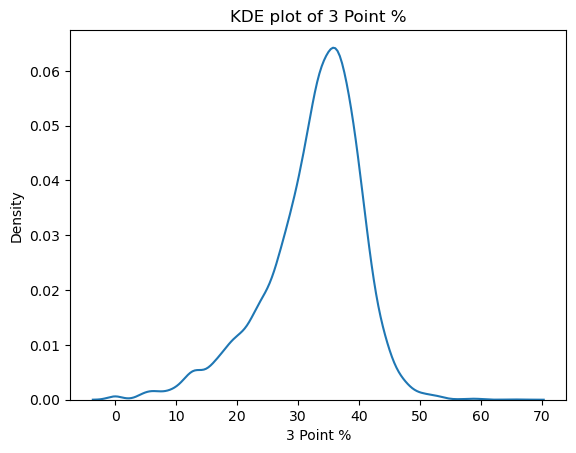

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


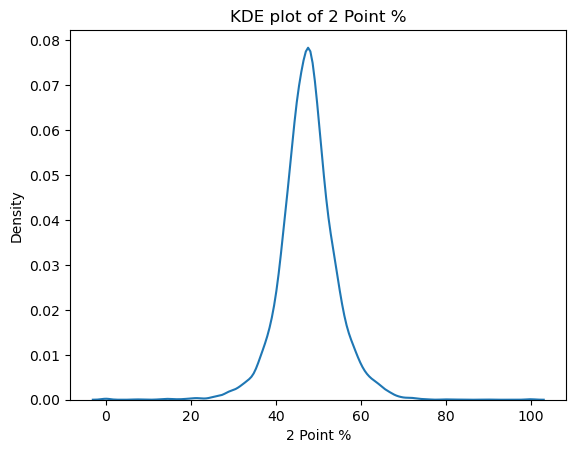

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


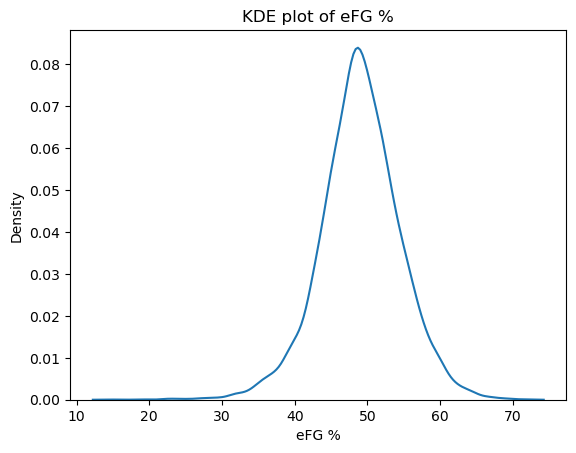

In [513]:
#Using Kernel Density Estimate plot to plot skewness and kurtosis
sns.kdeplot(df_final['x3p_percent'])
plt.title("KDE plot of 3 Point %")
plt.xlabel("3 Point %")
plt.show()

sns.kdeplot(df_final['x2p_percent'])
plt.title("KDE plot of 2 Point %")
plt.xlabel("2 Point %")
plt.show()

sns.kdeplot(df_final['e_fg_percent'])
plt.title("KDE plot of eFG %")
plt.xlabel("eFG %")
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


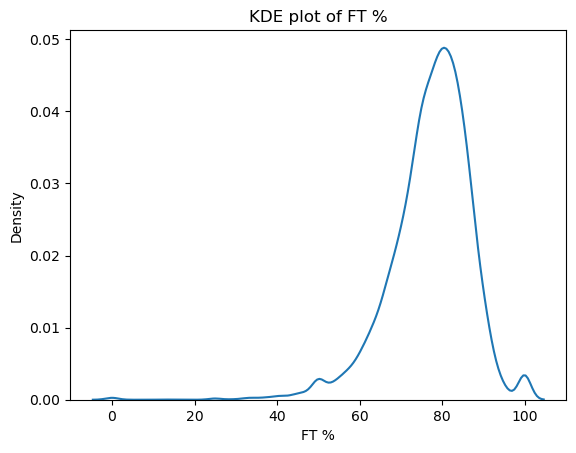

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


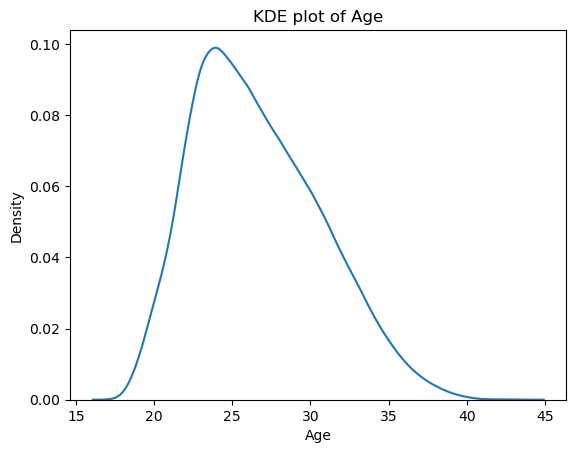

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


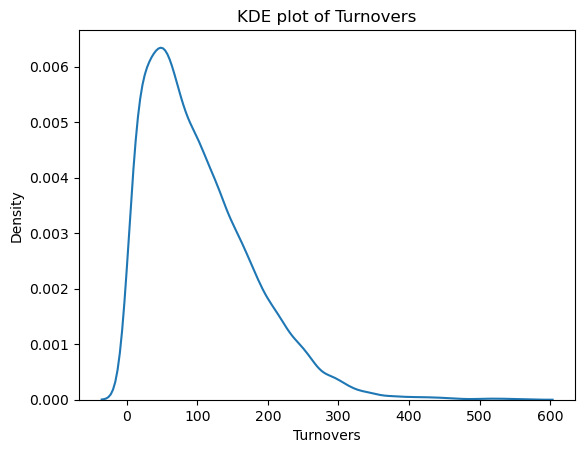

('ft_percent', 'age', 'tov')

In [490]:
sns.kdeplot(df_final['ft_percent'])
plt.title("KDE plot of FT %")
plt.xlabel("FT %")
plt.show()

sns.kdeplot(df_final['age'])
plt.title("KDE plot of Age")
plt.xlabel("Age")
plt.show()

sns.kdeplot(df_final['tov'])
plt.title("KDE plot of Turnovers")
plt.xlabel("Turnovers")
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


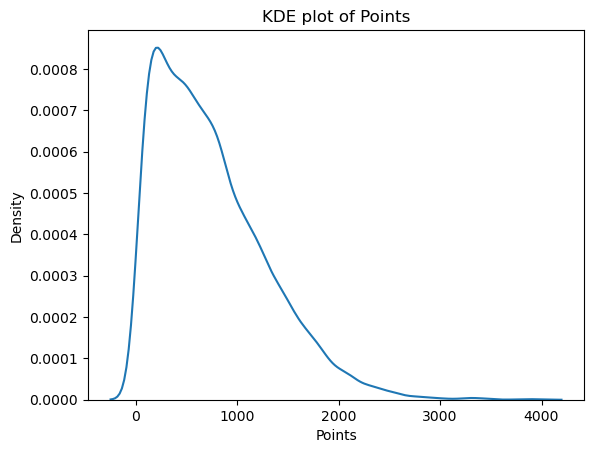

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


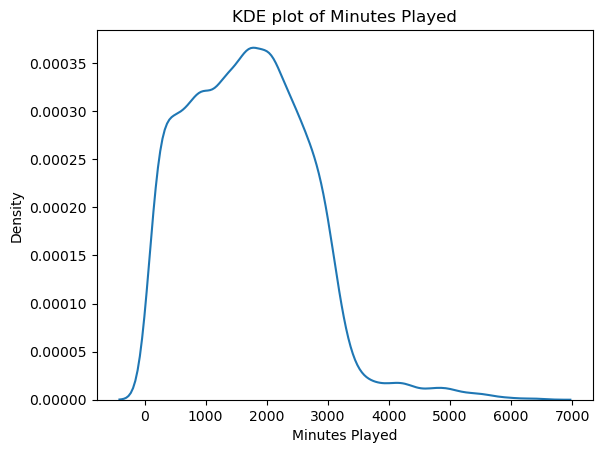

In [492]:
sns.kdeplot(df_final['pts'])
plt.title("KDE plot of Points")
plt.xlabel("Points")
plt.show()

sns.kdeplot(df_final['mp'])
plt.title("KDE plot of Minutes Played")
plt.xlabel("Minutes Played")
plt.show()

## Probability Mass Functions - More Distribution

For this section, I am going to create and plot probability mass functions to compare eFG% for all players vs players over the age of 30 and 35. I am interested to learn how increases in age impacts the distribution of eFG%, if at all. 

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


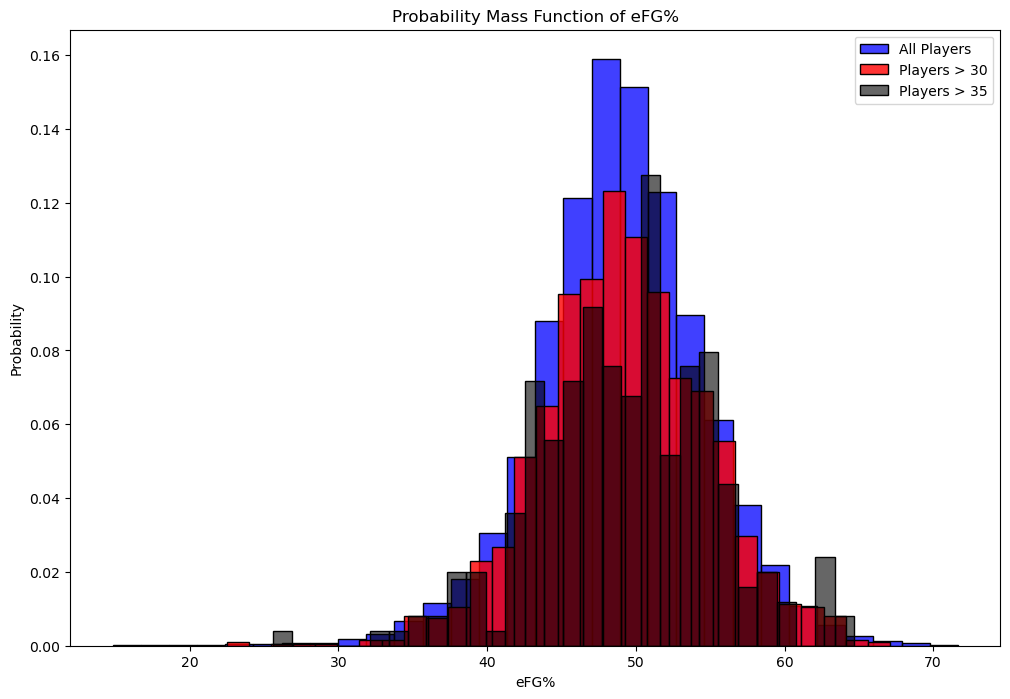

In [622]:
players_over_30 = df_final[df_final['age'] > 30]
players_over_35 = df_final[df_final['age'] > 35]

efg_all_players = df_final['e_fg_percent'].dropna()
efg_over_30 = players_over_30['e_fg_percent'].dropna()
efg_over_35 = players_over_35['e_fg_percent'].dropna()

plt.figure(figsize=(12, 8))

sns.histplot(efg_all_players, bins=30, kde=False, stat='probability', color='blue', label='All Players')
sns.histplot(efg_over_30, bins=30, kde=False, stat='probability', color='red', label='Players > 30', alpha = 0.8)
sns.histplot(efg_over_35, bins=30, kde=False, stat='probability', color='black', label='Players > 35', alpha = 0.6)

plt.title('Probability Mass Function of eFG%')
plt.xlabel('eFG%')
plt.ylabel('Probability')
plt.legend()

plt.show()

As shown above, the distribution is generally the same for all age groups. For players between 30-35, they still most commonly achieve an eFG% of around 50%. But for players over 35, their distribution is a bit less normal, that peaks above 50%. This could be mostly explained by a smaller sample of players that play into their late 30s - with those that do so being more likely to be high caliber players. 

## Cumulative Distribution Functions

For this section, I will create a Cumulative Distribution Function for age. This visualization will tell us the probability of a player playing a season at a given age. 

To be more clear, if you look at the chart below, if you incrementally step up in ages to the age of 30 (for instance), you will account for nearly 80% of all players. In other words, only 20% of players play past the age of 30. To take it even further, less than 5% of players play past the age of 35. 

This analysis is specifically focused on how age impacts performance. This visual simply reinforces the fact that very few players play much more than 10 years in the NBA. 

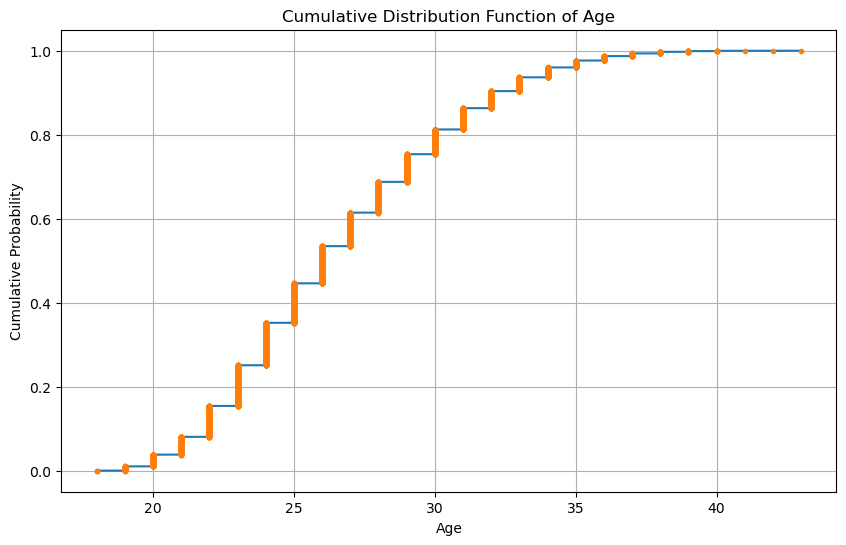

In [659]:
age = df_final['age'].dropna()

sorted_age = np.sort(age)

cdf = np.arange(1, len(sorted_age) + 1) / len(sorted_age)

plt.figure(figsize=(10, 6))
plt.step(sorted_age, cdf, where='mid')
plt.plot(sorted_age, cdf, marker='.', linestyle='none')
plt.title('Cumulative Distribution Function of Age')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

## Does Age Correlate with reduction in performance?

In this section, I will plot age against the metrics to visualize any relationship between them. My expectation is that at age increases, performance will decrease. This means less points, lower percentages, more turnovers, etc. 

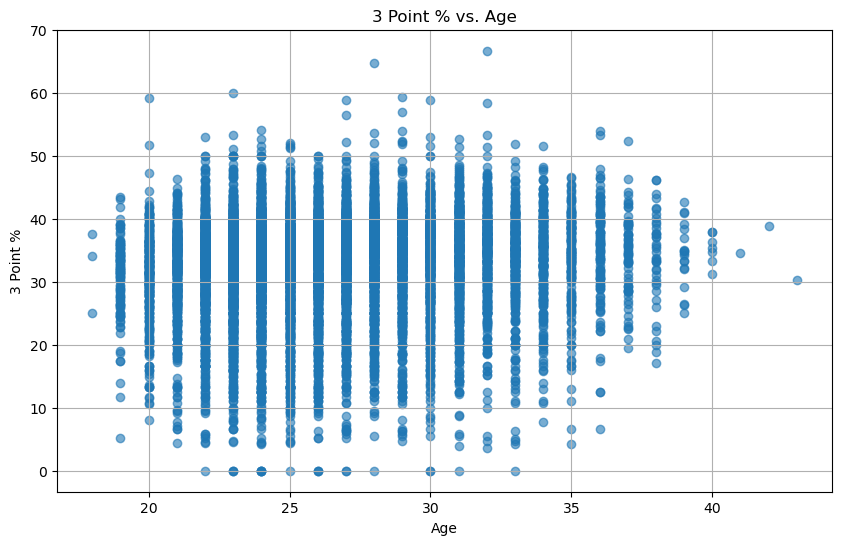

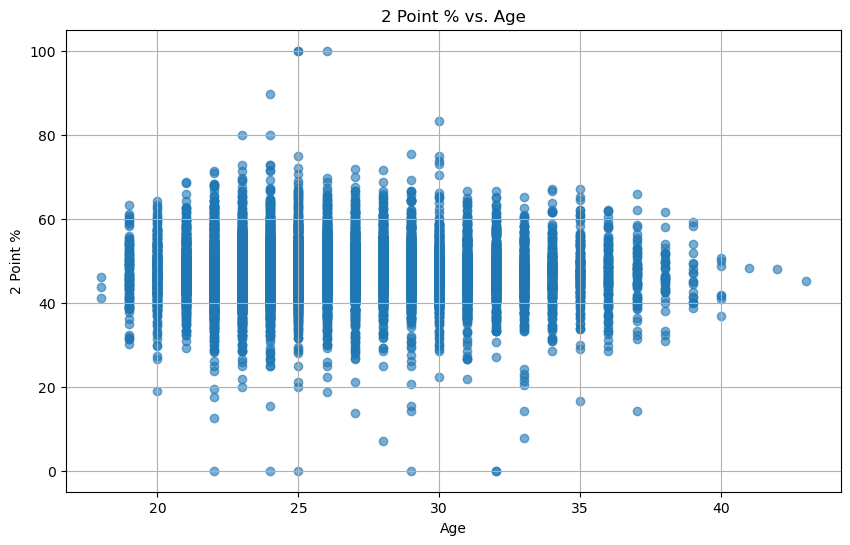

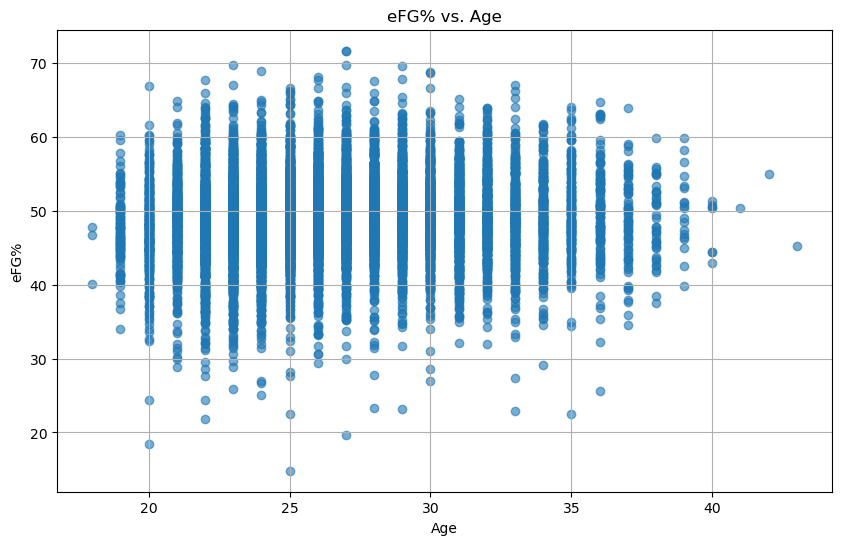

In [756]:
plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['x3p_percent'], alpha=0.6)
plt.title('3 Point % vs. Age')
plt.xlabel('Age')
plt.ylabel('3 Point %')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['x2p_percent'], alpha=0.6)
plt.title('2 Point % vs. Age')
plt.xlabel('Age')
plt.ylabel('2 Point %')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['e_fg_percent'], alpha=0.6)
plt.title('eFG% vs. Age')
plt.xlabel('Age')
plt.ylabel('eFG%')
plt.grid(True)
plt.show()

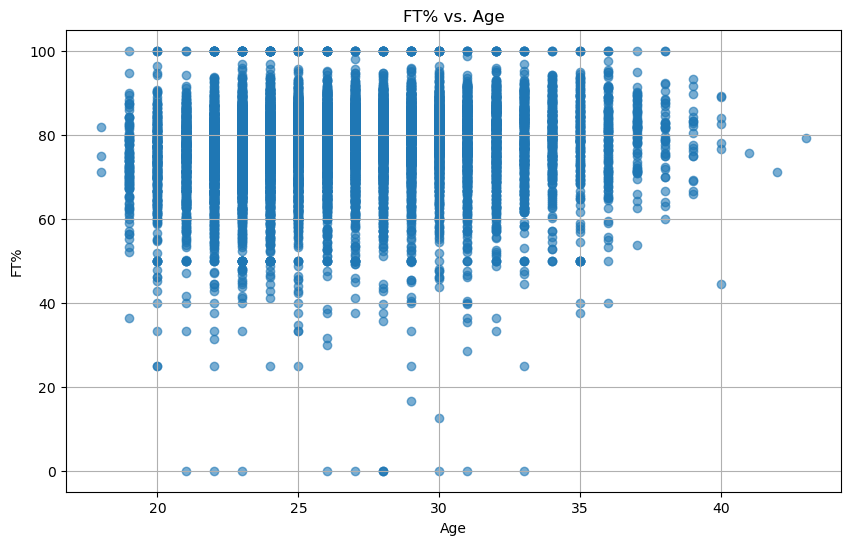

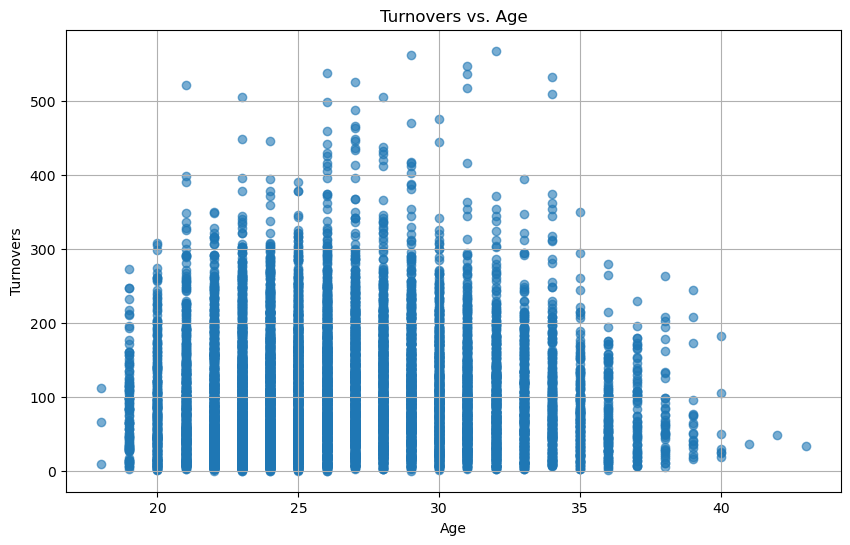

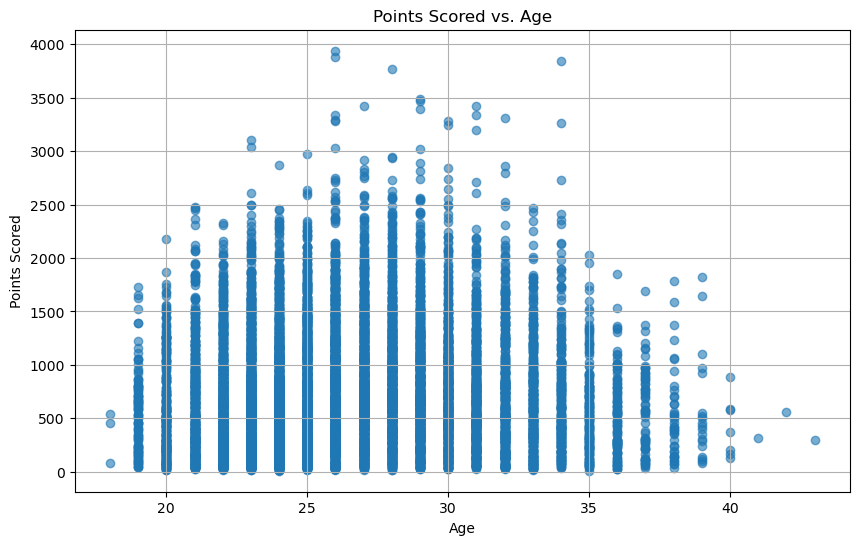

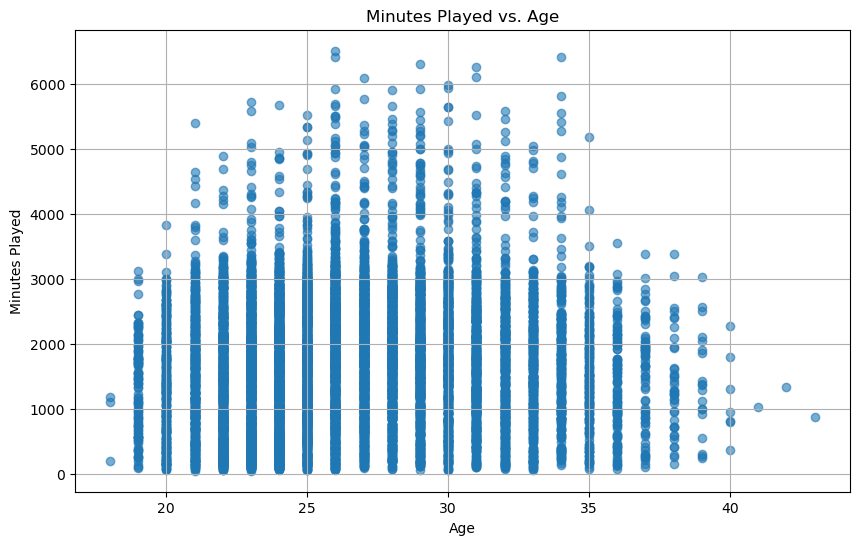

In [678]:
plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['ft_percent'], alpha=0.6)
plt.title('FT% vs. Age')
plt.xlabel('Age')
plt.ylabel('FT%')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['tov'], alpha=0.6)
plt.title('Turnovers vs. Age')
plt.xlabel('Age')
plt.ylabel('Turnovers')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['pts'], alpha=0.6)
plt.title('Points Scored vs. Age')
plt.xlabel('Age')
plt.ylabel('Points Scored')
plt.grid(True)
plt.show()

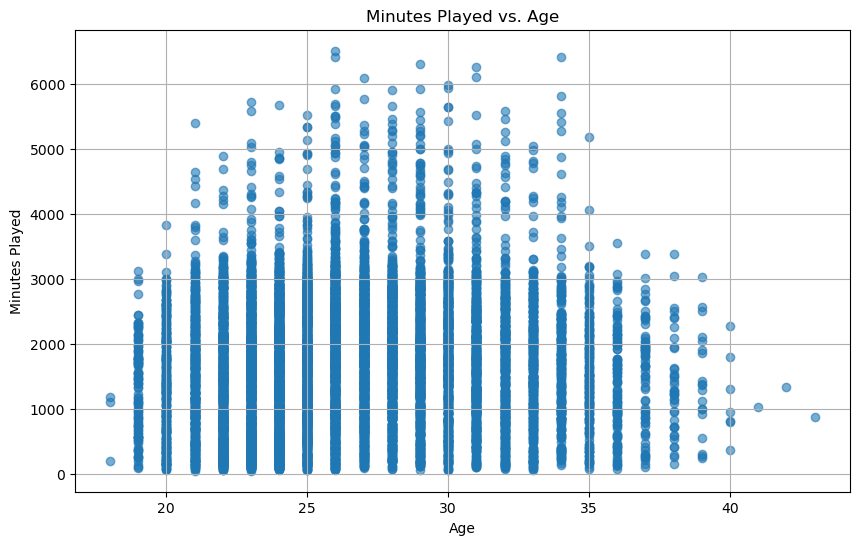

In [680]:
plt.figure(figsize=(10, 6))
plt.scatter(df_final['age'], df_final['mp'], alpha=0.6)
plt.title('Minutes Played vs. Age')
plt.xlabel('Age')
plt.ylabel('Minutes Played')
plt.grid(True)
plt.show()

Observations about these plots:

1. Surprisingly, it doesn't seem that shooting percentages decrease with age. That can possibly (again) be explained the small number of players that have longer careers are also typically above average shooters - even as they age.
2. As expected, minutes played does appear to decrease as age increases. Even for those players that are above average for decades, father time is undefeated.
3. One plot that I found particularly interesting, though, is turnovers vs age. It seems there is a negative correlation, implying that players have fewer turnovers as they age. This can likely be explained in two ways: 1. As discussed in point 2, players play fewer minutes as they age. This gives them less opportunities to turn the ball over and therefore by nature they will have fewer turnovers or 2. It's possible that older players are more careful with the basketball based on their skill/experience, and therefore have fewer turnovers as they age.

With these observations in mind, let's look at the covariances and correlations for each of the relationships to get a better understanding of how age relates to each of the variables. 

#### Correlation/Covariance

In [703]:
variables = {
    '3 Point %': df_final['x3p_percent'],
    '2 Point %': df_final['x2p_percent'],
    'eFG %': df_final['e_fg_percent'],
    'Turnovers': df_final['tov'],
    'Points': df_final['pts'],
    'Minutes Played': df_final['mp']
}

for var_name, var_data in variables.items():
    covariance = np.cov(var_data, df_final['age'])[0, 1]
    
    correlation = np.corrcoef(var_data, df_final['age'])[0, 1]
    
    print(f'Covariance between {var_name} and Age: {covariance}')
    print(f'Correlation between {var_name} and Age: {correlation}')
    print('')

Covariance between 3 Point % and Age: 3.657172894157367
Correlation between 3 Point % and Age: 0.11444980575627567

Covariance between 2 Point % and Age: -0.8618179357326112
Correlation between 2 Point % and Age: -0.032092623389642985

Covariance between eFG % and Age: 1.743022269555185
Correlation between eFG % and Age: 0.07723254770913224

Covariance between Turnovers and Age: 2.7461293263667494
Correlation between Turnovers and Age: 0.008844759282130112

Covariance between Points and Age: 74.66420072371272
Correlation between Points and Age: 0.033413468865709124

Covariance between Minutes Played and Age: 319.34935071021084
Correlation between Minutes Played and Age: 0.07968336461381166



Observations:

1. Based on these results, it seems clear that age does not have a large impact on any of the variables. The highest correlation value is 0.11 for 3 point % vs age, while all others are very close to 0.
2. With that in mind, 3 point % vs age having the highest correlation coefficient is certainly interesting. It's possible that players get better at shooting three pointers over time because their athleticism declines naturally with age. As a specific case, in his prime, Lebron James was one of the most athletically gifted players (or people, for that matter) to ever play in the NBA. As is expected, his athleticism has declined over the years (at the time of writing this, he just played a major role in beating Serbia in the 2024 Paris Olympics Semifinals, but let's ignore that for now), so he has improved his 3 point shooting ability dramatically to make up for his lost step. **This is shown in the graph below.** Aside from his 10th year in the league (as a 28 year old, when he won league MVP for the 3rd time), his 3 point percentage has generally been a steady incline with age. This specific trend might be true for other players as well and may explain the positive correlation.


#### Lebron James just might beat Father Time

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


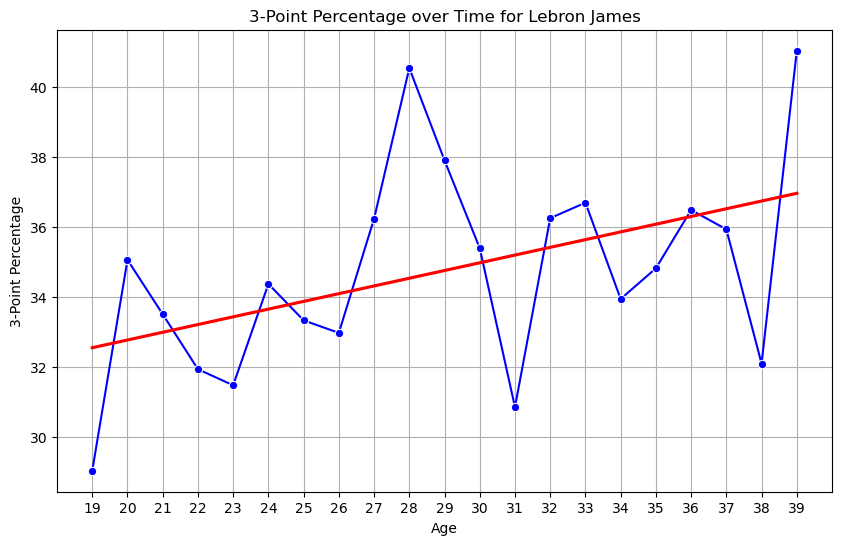

In [722]:
james_data = df_final[df_final['player_id'] == 3463]

plt.figure(figsize=(10, 6))
sns.lineplot(data=james_data, x='age', y='x3p_percent', marker='o', color='b')

sns.regplot(data=james_data, x='age', y='x3p_percent', scatter=False, color='r', ci=None)

# Formatting the x-axis to be discrete
plt.xticks(ticks=james_data['age'].unique())

plt.title('3-Point Percentage over Time for Lebron James')
plt.xlabel('Age')
plt.ylabel('3-Point Percentage')
plt.grid(True)
plt.show()


## Hypothesis Testing

In this section, I will test my hypothesis - age impacts performance - against all of the metrics used during this analysis. I will do so by conducting t-tests and therefore checking for statistically significant differences in each of the metrics for players of all ages vs players of age 30 or greater. 

In [747]:
variables = {
    '3 Point %': df_final['x3p_percent'],
    '2 Point %': df_final['x2p_percent'],
    'eFG %': df_final['e_fg_percent'],
    'Turnovers': df_final['tov'],
    'Points': df_final['pts'],
    'Minutes Played': df_final['mp']
}

results = {}

for var_name, var_data in variables.items():
    all_players_data = var_data.dropna()
    players_over_30_data = df_final[df_final['age'] > 30][var_data.name].dropna()
    
    t_stat, p_value = stats.ttest_ind(all_players_data, players_over_30_data, equal_var=False)
    
    results[var_name] = {'t_stat': t_stat, 'p_value': p_value}

for var_name, result in results.items():
    print(f'Variable: {var_name}')
    print(f'  T-statistic: {result["t_stat"]}')
    print(f'  P-value: {result["p_value"]}')
    
    if result['p_value'] < 0.05:
        print("The difference is statistically significant.")
    else:
        print("There is no statistically significant difference.")
    print('')

Variable: 3 Point %
  T-statistic: -6.600721187508644
  P-value: 4.854081383570507e-11
The difference is statistically significant.

Variable: 2 Point %
  T-statistic: 5.009158861690629
  P-value: 5.804135820763874e-07
The difference is statistically significant.

Variable: eFG %
  T-statistic: -1.3090828318949324
  P-value: 0.19061339250183354
There is no statistically significant difference.

Variable: Turnovers
  T-statistic: 4.676959134948731
  P-value: 3.0432865854365672e-06
The difference is statistically significant.

Variable: Points
  T-statistic: 4.664966563839156
  P-value: 3.2248906916687038e-06
The difference is statistically significant.

Variable: Minutes Played
  T-statistic: 1.2006780923513796
  P-value: 0.22997592009631762
There is no statistically significant difference.



The results of these t-tests are mostly as expected. Most metrics have a statistically significant difference when age increases. However, the most surprising result to call out is that differences in age do not have a statistically significant difference when it comes to minutes played. I'm having trouble coming up with reasons that this might be true. I'll just chalk it up to the Hall of Famers that play into their 40s. 

## Regression Analysis

In this final section of my analysis, I will conduct a regression analysis for each of my metrics vs age. This will help to further explain how changes in age affect changes in each metric, if at all. 

In [768]:
X = df_final[['age']]

X = sm.add_constant(X)

variables = {
    '3 Point %': df_final['x3p_percent'],
    '2 Point %': df_final['x2p_percent'],
    'eFG %': df_final['e_fg_percent'],
    'Turnovers': df_final['tov'],
    'Points': df_final['pts'],
    'Minutes Played': df_final['mp']
}

for var_name, var_data in variables.items():
    y = var_data
    
    model = sm.OLS(y, X).fit()
    
    print(f'Regression Analysis for {var_name}')
    print(model.summary())
    print('')

Regression Analysis for 3 Point %
                            OLS Regression Results                            
Dep. Variable:            x3p_percent   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     142.6
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           1.15e-32
Time:                        13:43:41   Log-Likelihood:                -37294.
No. Observations:               10747   AIC:                         7.459e+04
Df Residuals:                   10745   BIC:                         7.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7

Observations:

1. It is clear that age does not play much of a factor when it comes to these metrics. All of the R-Squared values are very small and therefore don't explain much of the changes in the metric given changes in age.
2. As I've mentinoed previously it's possible that the players that play longer into their lives also are more likely to have better careers even as they age. This may explain the lack or relationship between age and the metrics. 

## Conclusion

When I started this project, I was certain that age would play a factor in a player's performance over time. As I mentioned previously, father time is undefeated (and still is - see: Tom Brady). However, based on my tests, it seems clear that age does *not* play a big role in a player's performance. This can possibly be explained by a few factors: 
1. Great players are great regardless of their age. I'm sure Michael Jordan could still put up 20 points tomorrow night if the Charlotte Hornets needed him to.
2.  Bad (for lack of a better word) players are bad regardless of age. I'm sure there are plenty of players who enter the league as teenagers and don't perform at the level that is expected for their age group.
3.  It's very possible that the relationship between age and performance is not specifically linear. Maybe the relationship is parabolic, implying that there is a point in time in the middle of a players career that they perform at their highest. In a future analyis, I would like to explore this as a trend.

Overall, this project has been extremely satisfying and fulfilling. I'm certain that what I've done can be improved and won't be groundbreaking by any means, but as is the case for most things in life - it's not about the destination, it's about the journey. 

## References

1. https://en.wikipedia.org/wiki/Effective_field_goal_percentage
2. https://thejumphub.com/articles/the-introduction-and-evolution-of-the-3-point-shot-in-the-nba